# Project: Customer Purchase Analytics Part II: Predictive Analysis
Author: Wei Chong Ong

## Table of Contents
<ul>
<li><a href="#preparation">Data Preparation</a></li>
<li><a href="#predictive">Predictive Analysis - Price Elasticity
    <ul>
    <li><a href="#probability">Purchase Probability</a></li>
    <li><a href="#brand">Brand Choice</a></li>
    <li><a href="#quantity">Purchase Quantity</a></li>
    </ul>
    </a></li>
</ul>

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pickle
from sklearn.linear_model import LogisticRegression 
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.axes as axs
import seaborn as sns
sns.set()
from sklearn.linear_model import LinearRegression

<a id='preparation'></a>
## Data Preparation

In [2]:
# Load data
df_purchase = pd.read_csv('purchase data.csv')

# Import Scaler
scaler = pickle.load(open('scaler.pickle', 'rb'))

# Import PCA
pca = pickle.load(open('pca.pickle', 'rb'))

# Import K-Means
kmeans_pca = pickle.load(open('kmeans_pca.pickle', 'rb'))

# Standardization
features = df_purchase[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
df_purchase_segm_std = scaler.transform(features)

# Apply PCA
df_purchase_segm_pca = pca.transform(df_purchase_segm_std)

# Segment data
purchase_segm_kmeans_pca = kmeans_pca.predict(df_purchase_segm_pca)

# Create a copy of the data frame
df_purchase_predictors = df_purchase.copy()

# Add segment labels
df_purchase_predictors['Segment'] = purchase_segm_kmeans_pca
segment_dummies = pd.get_dummies(purchase_segm_kmeans_pca, prefix = 'Segment', prefix_sep = '_')
df_purchase_predictors = pd.concat([df_purchase_predictors, segment_dummies], axis = 1)

df_pa = df_purchase_predictors

<a id='predictive'></a>
## Predictive Analysis - Price Elasticity

$Price\: Elasticity,\: E = \frac{Percent\: change\: in\: economic\: outcome\: of\: interest\: (Units\: sold)}{1\: percent\: change\: in\: price}$

<a id='probability'></a>
### Purchase Probability

#### Data Preparation

In [3]:
Y = df_pa['Incidence']
X = pd.DataFrame()

# Calculate the average price across the five brands
X['Mean_Price'] = (df_pa['Price_1'] +
                   df_pa['Price_2'] +
                   df_pa['Price_3'] +
                   df_pa['Price_4'] +
                   df_pa['Price_5'] ) / 5

#### Binomial Logistic Regression
Use binomial logistic regression model to determine the probability of purchase where the dependant variable is based on the average price of the product.

In [4]:
model_purchase = LogisticRegression(solver = 'sag')
model_purchase.fit(X, Y)

LogisticRegression(solver='sag')

In [5]:
model_purchase.coef_

array([[-2.34759244]])

> A decrease in price would lead to an increase in purchase probability

### Price Elasticity of Purchase Probability

$E = \frac{\Delta Pr(Purchase)}{\Delta Price} * \frac{Price}{Pr(Purchase)} = \beta * \frac{Price}{Pr(Purchase)}$

In [6]:
df_pa[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


- The minimum price is 1.1 dollars and the maximum price is 2.8. 
- In this analysis will opt for the range between 0.5 and 3.5 in order to gain a better understanding of how the purchase probabilities and the respective elasticities change 

In [7]:
# Price range for examining the purchase probability
price_range = np.arange(0.5, 3.5, 0.01)
df_price_range = pd.DataFrame(price_range)

In [8]:
Y_pr = model_purchase.predict_proba(df_price_range)

- The first column shows the probability for not purchasing the product 
- The second column is the probability for purchase for each price point

In [9]:
# Compute price elasticity
purchase_pr = Y_pr[:][:, 1]
pe = model_purchase.coef_[:, 0] * price_range * (1 - purchase_pr)

In [10]:
# Create price elasticities master data frame
df_price_elasticities = pd.DataFrame(price_range)
df_price_elasticities = df_price_elasticities.rename(columns = {0: "Price_Point"})
df_price_elasticities['Mean_PE'] = pe
pd.options.display.max_rows = None
df_price_elasticities.head()

,Price_Point,Mean_PE
0,0.50,-0.096316
1,0.51,-0.100381
2,0.52,-0.104572
3,0.53,-0.108893
4,0.54,-0.113347


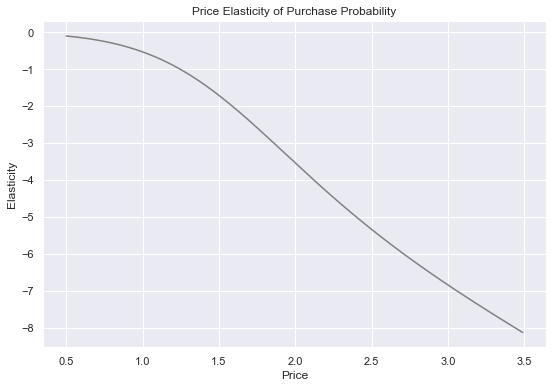

In [11]:
# Display the price elasticity of purchase probability of the average customer
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')
plt.show()

### Price Elasticity of Purchase Probability by Customer Segments

#### Fewer opportunities

In [12]:
# Filter the data to contain only customers from segment 1, the fewer opportunities
df_pa_segment_1 = df_pa[df_pa['Segment'] == 1]
Y = df_pa_segment_1['Incidence']
X = pd.DataFrame()
X['Mean_Price'] = (df_pa_segment_1['Price_1'] + 
                   df_pa_segment_1['Price_2'] + 
                   df_pa_segment_1['Price_3'] + 
                   df_pa_segment_1['Price_4'] + 
                   df_pa_segment_1['Price_5']) / 5

# Fit logistic regression model
model_incidence_segment_1 = LogisticRegression(solver = 'sag')
model_incidence_segment_1.fit(X, Y)

# Calculate Price Elasticity of the fewer opportunities segment
Y_segment_1 = model_incidence_segment_1.predict_proba(df_price_range)
purchase_pr_segment_1 = Y_segment_1[:][:, 1]
pe_segment1 = model_incidence_segment_1.coef_[:, 0] * price_range * (1 - purchase_pr_segment_1)

# Update price elasticities data frame
df_price_elasticities['PE_Segment_1'] = pe_segment1

#### Standard

In [13]:
# Select only customers from segment 2, the standard
df_pa_segment_2 = df_pa[df_pa['Segment'] == 2]
Y = df_pa_segment_2['Incidence']
X = pd.DataFrame()
X['Mean_Price'] = (df_pa_segment_2['Price_1'] + 
                   df_pa_segment_2['Price_2'] + 
                   df_pa_segment_2['Price_3'] + 
                   df_pa_segment_2['Price_4'] + 
                   df_pa_segment_2['Price_5']) / 5

# Logistic regression model
model_incidence_segment2 = LogisticRegression(solver = 'sag')
model_incidence_segment2.fit(X, Y)

# Calculate price elasticities
Y_segment_2 = model_incidence_segment2.predict_proba(df_price_range)
purchase_pr_segment2 = Y_segment_2[:][: , 1]
pe_segment2 = model_incidence_segment2.coef_[:,0] * price_range * ( 1- purchase_pr_segment2)

# Update price elasticities data frame
df_price_elasticities['PE_Segment_2'] = pe_segment2

#### Well-off

In [14]:
# Select only customers from segment 0, the well-off segment.
df_pa_segment_0 = df_pa[df_pa['Segment'] == 0]
Y = df_pa_segment_0['Incidence']
X = pd.DataFrame()
X['Mean_Price'] = (df_pa_segment_0['Price_1'] + 
                   df_pa_segment_0['Price_2'] + 
                   df_pa_segment_0['Price_3'] + 
                   df_pa_segment_0['Price_4'] + 
                   df_pa_segment_0['Price_5']) / 5

# Logistic regression model
model_incidence_segment0 = LogisticRegression(solver = 'sag')
model_incidence_segment0.fit(X, Y)

# Calculate price elasticities
Y_segment_0 = model_incidence_segment0.predict_proba(df_price_range)
purchase_pr_segment0 = Y_segment_0[:][: , 1]
pe_segment0 = model_incidence_segment0.coef_[:,0] * price_range *( 1- purchase_pr_segment0)

# Update price elasticities data frame
df_price_elasticities.insert(2, column = 'PE_Segment_0', value = pe_segment0)

#### Career focused

In [15]:
# Select only customers from segment 3 
df_pa_segment_3 = df_pa[df_pa['Segment'] == 3]
Y = df_pa_segment_3['Incidence']
X = pd.DataFrame()
X['Mean_Price'] = (df_pa_segment_3['Price_1'] + 
                   df_pa_segment_3['Price_2'] + 
                   df_pa_segment_3['Price_3'] + 
                   df_pa_segment_3['Price_4'] + 
                   df_pa_segment_3['Price_5']) / 5

# Logistic regression model
model_incidence_segment3 = LogisticRegression(solver = 'sag')
model_incidence_segment3.fit(X, Y)

# Calculate price elasticities
Y_segment_3 = model_incidence_segment3.predict_proba(df_price_range)
purchase_pr_segment3 = Y_segment_3[:][: , 1]
pe_segment3 = model_incidence_segment3.coef_[:,0] * price_range *( 1- purchase_pr_segment3)
df_price_elasticities['PE_Segment_3'] = pe_segment3

In [16]:
# Update price elasticities data frame
df_price_elasticities.head()

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3
0,0.50,-0.096316,-0.032421,-0.118585,-0.211172,-0.165258
1,0.51,-0.100381,-0.034260,-0.122766,-0.217742,-0.170177
2,0.52,-0.104572,-0.036190,-0.127040,-0.224420,-0.175170
3,0.53,-0.108893,-0.038213,-0.131410,-0.231206,-0.180236
4,0.54,-0.113347,-0.040334,-0.135877,-0.238102,-0.185378


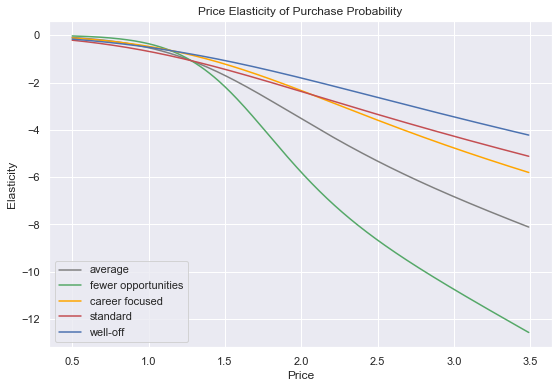

In [17]:
# Display all elasticities of purchase probability
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey', label = 'average')
plt.plot(price_range, pe_segment0, color = 'g', label = 'fewer opportunities')
plt.plot(price_range, pe_segment1, color = 'orange', label = 'career focused')
plt.plot(price_range, pe_segment2, color = 'r', label = 'standard')
plt.plot(price_range, pe_segment3, color = 'b', label = 'well-off')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.legend()
plt.title('Price Elasticity of Purchase Probability')
plt.show()

> **Results and Interpretation:**
- Career focused segment: This segment is less elastic than the average customer
- Fewer opportunities segment: This segment is more price sensitive compared to the average and a lot more sensitive compared to the career focused. The line is much steeper. This means that with an increase in price, they become more and more elastic much faster.
- Well-off segment: This segment is the least elastic when compared to the rest, so, their purchase probability elasticity is not as affected by price.
- The price elasticities for the Standard segment seem to differ across price range. This may be due to the fact that the standard segment is least homogenous.

### Purchase Probability with Promotion Feature

#### Data Preparation

In [18]:
Y = df_pa['Incidence']
X = pd.DataFrame()

# Calculate the average price across the five brands
X['Mean_Price'] = (df_pa['Price_1'] + 
                   df_pa['Price_2'] + 
                   df_pa['Price_3'] + 
                   df_pa['Price_4'] + 
                   df_pa['Price_5']) / 5

# Calculate the average promotion rate across the five brands
X['Mean_Promotion'] = (df_pa['Promotion_1'] +
                       df_pa['Promotion_2'] +
                       df_pa['Promotion_3'] +
                       df_pa['Promotion_4'] +
                       df_pa['Promotion_5'] ) / 5

#### Binomial Logistic Regression

In [19]:
model_incidence_promotion = LogisticRegression(solver = 'sag')
model_incidence_promotion.fit(X, Y)

LogisticRegression(solver='sag')

### Price Elasticity with Promotion

In [20]:
df_price_elasticity_promotion = pd.DataFrame(price_range)
df_price_elasticity_promotion = df_price_elasticity_promotion.rename(columns = {0: "Price_Range"})

# Assume there is a promotion across at each price points
df_price_elasticity_promotion['Promotion'] = 1

# Purchase Probability with Promotion Model Prediction
Y_promotion = model_incidence_promotion.predict_proba(df_price_elasticity_promotion)
promo = Y_promotion[:, 1]
price_elasticity_promo = (model_incidence_promotion.coef_[:, 0] * price_range) * (1 - promo)

# Update price elasticities data frame
df_price_elasticities['Elasticity_Promotion_1'] = price_elasticity_promo

### Price Elasticity without Promotion

In [21]:
df_price_elasticity_promotion_no = pd.DataFrame(price_range)
df_price_elasticity_promotion_no = df_price_elasticity_promotion_no.rename(columns = {0: "Price_Range"})

# Assume there is no promotion across at each price points
df_price_elasticity_promotion_no['Promotion'] = 0

#Purchase Probability without Promotion Model Prediction
Y_no_promo = model_incidence_promotion.predict_proba(df_price_elasticity_promotion_no)
no_promo = Y_no_promo[: , 1]
price_elasticity_no_promo = model_incidence_promotion.coef_[:, 0] * price_range *(1 - no_promo)

# Update price elasticities data frame
df_price_elasticities['Elasticity_Promotion_0'] = price_elasticity_no_promo

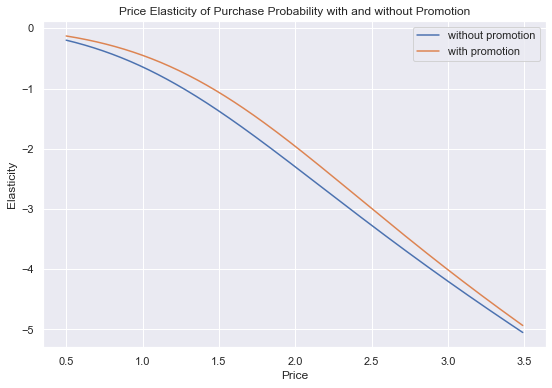

In [22]:
# Plot purchase elasticities with and without promotion side by side for comprarisson
plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_no_promo, label='without promotion')
plt.plot(price_range, price_elasticity_promo, label='with promotion')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.legend()
plt.title('Price Elasticity of Purchase Probability with and without Promotion')
plt.show()

> **Results and Interpretation:**
- Customers are less price sensitive to price changes when there are promotion activities

<a id='brand'></a>
### Brand Choice
Marketer's efforts are devoted to influencing customers to choose namely their brand over competing brands. If the price of a product from a given brand increases the brand choice probability for that brand decreases. Calculating price elasticity of brand choice for a brand with respect to the price of that brand would show us exactly how much.

The choice probability for any one brand and the choice probabilities for all the other brands are interrelated and a marketing mix tool of our brand reflects not only the choice probability for that brand but the choice probabilities for all other brands as well. These effects are known as **own brand effects** and **cross brand effects**.

If another brand increases its unit price, the brand choice probability of the brand of interest would increase. Price elasticity calculations will show us how much the brand choice profitability of our brand would increase with a 1 percent increase in the price of a competing brand.

#### Data Preparation

In [23]:
brand_choice = df_pa[df_pa['Incidence'] == 1]

# Predict based on the prices for the five brands.
features = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
Y = brand_choice['Brand']
X = brand_choice[features]

#### Multinomial Logistic Regression
Multinomial logistic regression model to predict brand choice probability based on the prices for the brands.

In [24]:
model_brand_choice = LogisticRegression(solver = 'sag', multi_class = 'multinomial')
model_brand_choice.fit(X, Y)

LogisticRegression(multi_class='multinomial', solver='sag')

In [25]:
# Create a dataframe, which contains to coefficients.
bc_coef = pd.DataFrame(model_brand_choice.coef_)
bc_coef = pd.DataFrame(np.transpose(model_brand_choice.coef_))
coefficients = ['Coef_Brand_1', 'Coef_Brand_2', 'Coef_Brand_3', 'Coef_Brand_4', 'Coef_Brand_5']
bc_coef.columns = [coefficients]
prices = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-3.92,1.27,1.62,0.57,0.44
Price_2,0.66,-1.88,0.56,0.40,0.26
Price_3,2.42,-0.21,0.50,-1.40,-1.31
Price_4,0.70,-0.21,1.04,-1.25,-0.29
Price_5,-0.20,0.59,0.45,0.25,-1.09


> **Results and Interpretation:**
- By looking at the coefficients of Brand 1, the coefficient for the own brand with respect to price is negative while it's positive for all other prices except five, i.e. the more the price of a competitor increases, the higher the probability of customers switching to our own brand would be. Hence, there is a positive relationship between our own brands purchase probability and a competitive brand increasing their price.
- The choice probability for any one brand and the choice probabilities for all the other brands are interrelated and a marketing mix tool of our brand reflects not only the choice probability for that brand but the choice probabilities for all other brands as well. These effects are known as **own brand effects** and **cross brand effects**.

### Own Price Elasticity

$E_{own\: brand} = \beta_{own\: brand} * \frac{Price_{own\: brand}}{Pr(own\: brand)}$

#### Brand 5

In [26]:
# Calculate price elasticity of brand choice.
df_own_brand_5 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5['Price_1'] = brand_choice['Price_1'].mean()
df_own_brand_5['Price_2'] = brand_choice['Price_2'].mean()
df_own_brand_5['Price_3'] = brand_choice['Price_3'].mean()
df_own_brand_5['Price_4'] = brand_choice['Price_4'].mean()
df_own_brand_5['Price_5'] = price_range

In [27]:
# Brand choice model prediction
predict_brand_5 = model_brand_choice.predict_proba(df_own_brand_5)

# Obtain the probability for the fifth brand
pr_own_brand_5 = predict_brand_5[: ][:, 4]

# Obtain the beta coefficient of brand 5 and price 5
beta5 = bc_coef.iloc[4, 4]

# Calculating price elasticities for brand choice without promotion. 
own_price_elasticity_brand_5 = beta5 * price_range * (1 - pr_own_brand_5)


# Update price elasticities data frame
df_price_elasticities['Brand_5'] = own_price_elasticity_brand_5

### Cross Price Elasticity

$E_{cross\: brand} = -\beta_{own\: brand} * \frac{Price_{cross\: brand}}{Pr(cross\: brand)}$

#### Brand 5, Cross Brand 4

In [28]:
# Examine the effect of the changes in price of a competitor brand
# Brand 4 price is the closest to brand 5
df_brand5_cross_brand4 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4['Price_1'] = brand_choice['Price_1'].mean()
df_brand5_cross_brand4['Price_2'] = brand_choice['Price_2'].mean()
df_brand5_cross_brand4['Price_3'] = brand_choice['Price_3'].mean()
df_brand5_cross_brand4['Price_4'] = price_range
df_brand5_cross_brand4['Price_5'] = brand_choice['Price_5'].mean()

In [29]:
# Brand choice model prediction
predict_brand5_cross_brand4 = model_brand_choice.predict_proba(df_brand5_cross_brand4)

# Obtain the probability for the fourth brand
pr_brand_4 = predict_brand5_cross_brand4[:][:, 3]

# Calculating the cross brand price elasticities
brand5_cross_brand4_price_elasticity = -beta5 * price_range * pr_brand_4

# Update price elasticities data frame
df_price_elasticities['Brand_5_Cross_Brand_4'] = brand5_cross_brand4_price_elasticity

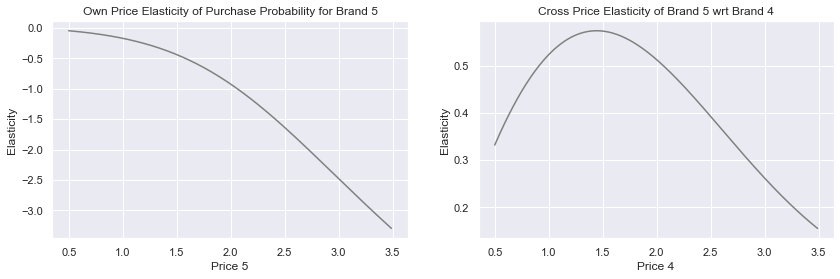

In [30]:
# Plot elasticities of purchase probability for brand 5
# Plot cross price elasticity of purchase probability for brand 5 with respect to brand 4
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
axs[0].plot(price_range, own_price_elasticity_brand_5, color = 'grey')
axs[0].set_title('Own Price Elasticity of Purchase Probability for Brand 5')
axs[0].set_xlabel('Price 5')

axs[1].plot(price_range, brand5_cross_brand4_price_elasticity, color = 'grey')
axs[1].set_title('Cross Price Elasticity of Brand 5 wrt Brand 4')
axs[1].set_xlabel('Price 4')

for ax in axs.flat:
    ax.set(ylabel = 'Elasticity')

> **Results and Interpretation:**
- Brand 4 is a strong substitute for brand 5 for all price up to 1.65
- However, price range of brand 4 is between 1.76 and 2.26. At this price range, the elasticity is positive. Brand 5 purchase probability still increases with the increase in price of brand 4, but at a slower rate.
- When it comes to the average customer, brand 4 is an albeit weak substitute for brand 5. In light of these results, brand 5 can create a marketing strategy for targeting customers which choose brand 4 and attract them to buy the own brand.

### Own and Cross-Price Elasticity by Customer Segments

#### Fewer opportunities

In [31]:
# Filter data to contain only purchase incidences by fewer opportunities segment
brand_choice_s0 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s0 = brand_choice_s0[brand_choice_s0['Segment'] == 0]

# Brand choice model estimation
Y = brand_choice_s0['Brand']
brand_choice_s0 = pd.get_dummies(brand_choice_s0, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s0[features]
model_brand_choice_s0 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s0.fit(X, Y)

# Coefficients table
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s0.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

# Calculate own-brand price elasticity for brand 5 
df_own_brand_5_s0 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s0['Price_1'] = brand_choice_s0['Price_1'].mean()
df_own_brand_5_s0['Price_2'] = brand_choice_s0['Price_2'].mean()
df_own_brand_5_s0['Price_3'] = brand_choice_s0['Price_3'].mean()
df_own_brand_5_s0['Price_4'] = brand_choice_s0['Price_4'].mean()
df_own_brand_5_s0['Price_5'] = price_range

predict_own_brand_5_s0 = model_brand_choice_s0.predict_proba(df_own_brand_5_s0)
pr_own_brand_5_s0 = predict_own_brand_5_s0[: ][: , 4]

# Compute price elasticities and update master data frame
own_price_elasticity_brand_5_s0 =  beta5 * price_range * (1 - pr_own_brand_5_s0)
df_price_elasticities['Brand_5_S0'] = own_price_elasticity_brand_5_s0

# Calculate cross-brand price elasticity for brand 5 with respect to brand 4
df_brand5_cross_brand4_s0 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s0['Price_1'] = brand_choice_s0['Price_1'].mean()
df_brand5_cross_brand4_s0['Price_2'] = brand_choice_s0['Price_2'].mean()
df_brand5_cross_brand4_s0['Price_3'] = brand_choice_s0['Price_3'].mean()
df_brand5_cross_brand4_s0['Price_4'] = price_range
df_brand5_cross_brand4_s0['Price_5'] = brand_choice_s0['Price_5'].mean()

predict_brand5_cross_brand4_s0 = model_brand_choice_s0.predict_proba(df_brand5_cross_brand4_s0)
pr_cross_brand_5_s0 = predict_brand5_cross_brand4_s0[: ][: , 3]

# Compute cross price elasticities and update master data frame
brand5_cross_brand4_price_elasticity_s0 = -beta5 * price_range * pr_cross_brand_5_s0
df_price_elasticities['Brand_5_Cross_Brand_4_S0'] = brand5_cross_brand4_price_elasticity_s0

#### Career focused

In [32]:
# Filter data to contain only purchase incidences by career focused segment
brand_choice_s1 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s1 = brand_choice_s1[brand_choice_s1['Segment'] == 1]

# Brand choice model estimation
Y = brand_choice_s1['Brand']
brand_choice_s1 = pd.get_dummies(brand_choice_s1, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s1[features]
model_brand_choice_s1 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s1.fit(X, Y)

# Coefficients table
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s1.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

# Calculate own-brand price elasticity for brand 5 
df_own_brand_5_s1 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s1['Price_1'] = brand_choice_s1['Price_1'].mean()
df_own_brand_5_s1['Price_2'] = brand_choice_s1['Price_2'].mean()
df_own_brand_5_s1['Price_3'] = brand_choice_s1['Price_3'].mean()
df_own_brand_5_s1['Price_4'] = brand_choice_s1['Price_4'].mean()
df_own_brand_5_s1['Price_5'] = price_range

predict_own_brand_5_s1 = model_brand_choice_s1.predict_proba(df_own_brand_5_s1)
pr_own_brand_5_s1 = predict_own_brand_5_s1[: ][: , 4]

# Compute price elasticities and update master data frame
own_price_elasticity_brand_5_s1 =  beta5 * price_range * (1 - pr_own_brand_5_s1)
df_price_elasticities['Brand_5_S1'] = own_price_elasticity_brand_5_s1

# Calculate cross-brand price elasticity for brand 5 with respect to brand 4 
df_brand5_cross_brand4_s1 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s1['Price_1'] = brand_choice_s1['Price_1'].mean()
df_brand5_cross_brand4_s1['Price_2'] = brand_choice_s1['Price_2'].mean()
df_brand5_cross_brand4_s1['Price_3'] = brand_choice_s1['Price_3'].mean()
df_brand5_cross_brand4_s1['Price_4'] = price_range
df_brand5_cross_brand4_s1['Price_5'] = brand_choice_s1['Price_5'].mean()

predict_brand5_cross_brand4_s1 = model_brand_choice_s1.predict_proba(df_brand5_cross_brand4_s1)
pr_cross_brand_5_s1 = predict_brand5_cross_brand4_s1[: ][: , 3]

# Compute cross price elasticities and update master data frame
brand5_cross_brand4_price_elasticity_s1 = -beta5 * price_range * pr_cross_brand_5_s1
df_price_elasticities['Brand_5_Cross_Brand_4_S1'] = brand5_cross_brand4_price_elasticity_s1

#### Standard

In [33]:
# Filter data to contain only purchase incidences by standard segment
brand_choice_s2 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s2 = brand_choice_s2[brand_choice_s2['Segment'] == 2]

# Brand choice model estimation
Y = brand_choice_s2['Brand']
brand_choice_s2 = pd.get_dummies(brand_choice_s2, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s2[features]
model_brand_choice_s2 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s2.fit(X, Y)

# Coefficients table
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s2.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

# Calculate own-brand price elasticity for brand 5
df_own_brand_5_s2 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s2['Price_1'] = brand_choice_s2['Price_1'].mean()
df_own_brand_5_s2['Price_2'] = brand_choice_s2['Price_2'].mean()
df_own_brand_5_s2['Price_3'] = brand_choice_s2['Price_3'].mean()
df_own_brand_5_s2['Price_4'] = brand_choice_s2['Price_4'].mean()
df_own_brand_5_s2['Price_5'] = price_range

predict_own_brand_5_s2 = model_brand_choice_s2.predict_proba(df_own_brand_5_s2)
pr_own_brand_5_s2 = predict_own_brand_5_s2[: ][: , 4]

# Compute price elasticities and update master data frame
own_price_elasticity_brand_5_s2 =  beta5 * price_range * (1 - pr_own_brand_5_s2)
df_price_elasticities['Brand_5_S2'] = own_price_elasticity_brand_5_s2

# Calculate cross-brand price elasticity for brand 5 with respect to brand 4 
df_brand5_cross_brand4_s2 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s2['Price_1'] = brand_choice_s2['Price_1'].mean()
df_brand5_cross_brand4_s2['Price_2'] = brand_choice_s2['Price_2'].mean()
df_brand5_cross_brand4_s2['Price_3'] = brand_choice_s2['Price_3'].mean()
df_brand5_cross_brand4_s2['Price_4'] = price_range
df_brand5_cross_brand4_s2['Price_5'] = brand_choice_s2['Price_5'].mean()

predict_brand5_cross_brand4_s2 = model_brand_choice_s2.predict_proba(df_brand5_cross_brand4_s2)
pr_cross_brand_5_s2 = predict_brand5_cross_brand4_s2[: ][: , 3]

# Compute cross price elasticities and update master data frame
brand5_cross_brand4_price_elasticity_s2 = -beta5 * price_range * pr_cross_brand_5_s2
df_price_elasticities['Brand_5_Cross_Brand_4_S2'] = brand5_cross_brand4_price_elasticity_s2

#### Well-off

In [34]:
# Filter data to contain only purchase incidences by well-off segment
brand_choice_s3 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s3 = brand_choice_s3[brand_choice_s3['Segment'] == 3]

# Brand choice model estimation
Y = brand_choice_s3['Brand']
brand_choice_s3 = pd.get_dummies(brand_choice_s3, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s3[features]
model_brand_choice_s3 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s3.fit(X, Y)

# Coefficients table
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s3.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

# Calculate own-brand price elasticity for brand 5
df_own_brand_5_s3 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s3['Price_1'] = brand_choice_s3['Price_1'].mean()
df_own_brand_5_s3['Price_2'] = brand_choice_s3['Price_2'].mean()
df_own_brand_5_s3['Price_3'] = brand_choice_s3['Price_3'].mean()
df_own_brand_5_s3['Price_4'] = brand_choice_s3['Price_4'].mean()
df_own_brand_5_s3['Price_5'] = price_range

predict_own_brand_5_s3 = model_brand_choice_s3.predict_proba(df_own_brand_5_s3)
pr_own_brand_5_s3 = predict_own_brand_5_s3[: ][: , 4]

# Compute price elasticities and update master data frame
own_price_elasticity_brand_5_s3 =  beta5 * price_range * (1 - pr_own_brand_5_s3)
df_price_elasticities['Brand_5_S3'] = own_price_elasticity_brand_5_s3

# Calculate cross-brand price elasticity for brand 5 with respect to brand 4 
df_brand5_cross_brand4_s3 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s3['Price_1'] = brand_choice_s3['Price_1'].mean()
df_brand5_cross_brand4_s3['Price_2'] = brand_choice_s3['Price_2'].mean()
df_brand5_cross_brand4_s3['Price_3'] = brand_choice_s3['Price_3'].mean()
df_brand5_cross_brand4_s3['Price_4'] = price_range
df_brand5_cross_brand4_s3['Price_5'] = brand_choice_s3['Price_5'].mean()

predict_brand5_cross_brand4_s3 = model_brand_choice_s3.predict_proba(df_brand5_cross_brand4_s3)
pr_cross_brand_5_s3 = predict_brand5_cross_brand4_s3[: ][: , 3]

# Compute cross price elasticities and update master data frame
brand5_cross_brand4_price_elasticity_s3 = -beta5 * price_range * pr_cross_brand_5_s3
df_price_elasticities['Brand_5_Cross_Brand_4_S3'] = brand5_cross_brand4_price_elasticity_s3

In [35]:
df_price_elasticities.head()

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand_5_S0,Brand_5_Cross_Brand_4_S0,Brand_5_S1,Brand_5_Cross_Brand_4_S1,Brand_5_S2,Brand_5_Cross_Brand_4_S2,Brand_5_S3,Brand_5_Cross_Brand_4_S3
0,0.50,-0.096316,-0.032421,-0.118585,-0.211172,-0.165258,-0.125782,-0.195675,-0.049055,0.332012,-0.001038,0.172835,-0.039243,0.196463,-0.115839,0.174120,-0.298403,0.482872
1,0.51,-0.100381,-0.034260,-0.122766,-0.217742,-0.170177,-0.129899,-0.201797,-0.050616,0.337288,-0.001100,0.175106,-0.040244,0.198958,-0.118879,0.176176,-0.304462,0.492184
2,0.52,-0.104572,-0.036190,-0.127040,-0.224420,-0.175170,-0.134096,-0.208021,-0.052206,0.342507,-0.001165,0.177333,-0.041256,0.201401,-0.121953,0.178180,-0.310530,0.501481
3,0.53,-0.108893,-0.038213,-0.131410,-0.231206,-0.180236,-0.138372,-0.214348,-0.053827,0.347669,-0.001233,0.179516,-0.042277,0.203793,-0.125062,0.180134,-0.316608,0.510761
4,0.54,-0.113347,-0.040334,-0.135877,-0.238102,-0.185378,-0.142729,-0.220780,-0.055477,0.352773,-0.001305,0.181656,-0.043309,0.206134,-0.128206,0.182038,-0.322698,0.520026


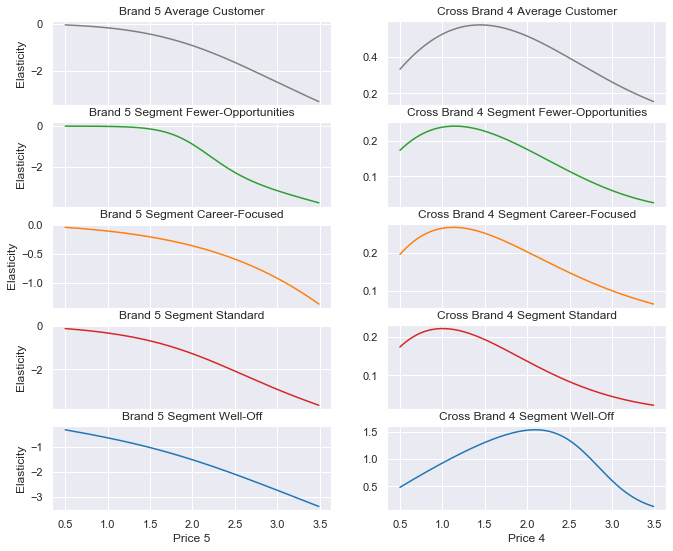

In [36]:
# Plot the own and cross brand price elasticities for the average customer and each of the four segments.
fig1, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 2, figsize = (11, 9), sharex = True)
ax1[0].plot(price_range, own_price_elasticity_brand_5, 'tab:grey')
ax1[0].set_title('Brand 5 Average Customer')
ax1[0].set_ylabel('Elasticity')
ax1[1].plot(price_range, brand5_cross_brand4_price_elasticity, 'tab:grey')
ax1[1].set_title('Cross Brand 4 Average Customer')

ax2[0].plot(price_range, own_price_elasticity_brand_5_s0, 'tab:green')
ax2[0].set_title('Brand 5 Segment Fewer-Opportunities')
ax2[0].set_ylabel('Elasticity')
ax2[1].plot(price_range, brand5_cross_brand4_price_elasticity_s0, 'tab:green')
ax2[1].set_title('Cross Brand 4 Segment Fewer-Opportunities')

ax3[0].plot(price_range, own_price_elasticity_brand_5_s1, 'tab:orange')
ax3[0].set_title('Brand 5 Segment Career-Focused')
ax3[0].set_ylabel('Elasticity')
ax3[1].plot(price_range, brand5_cross_brand4_price_elasticity_s1, 'tab:orange')
ax3[1].set_title('Cross Brand 4 Segment Career-Focused')

ax4[0].plot(price_range, own_price_elasticity_brand_5_s2, 'tab:red')
ax4[0].set_title('Brand 5 Segment Standard')
ax4[0].set_ylabel('Elasticity')
ax4[1].plot(price_range, brand5_cross_brand4_price_elasticity_s2, 'tab:red')
ax4[1].set_title('Cross Brand 4 Segment Standard')

ax5[0].plot(price_range, own_price_elasticity_brand_5_s3, 'tab:blue')
ax5[0].set_title('Brand 5 Segment Well-Off')
ax5[0].set_xlabel('Price 5')
ax5[0].set_ylabel('Elasticity')
ax5[1].plot(price_range, brand5_cross_brand4_price_elasticity_s3, 'tab:blue')
ax5[1].set_title('Cross Brand 4 Segment Well-Off')
ax5[1].set_xlabel('Price 4');

> **Results and Interpretation:**
- Standard customer is more elastic when compared to the average. The difference becomes even more pronounced when compared the standards to career focused and well-off segment in the price range 2.1-2.8. The elasticity of the standard segment is between -1.42 and -2.7. Therefore, its purchase probability for the own brand is elastic for the entire observed price range of the brand.
- Career focused customers are the least elastic among the rest. They are inelastic throughout the whole price range. It means this segment is not really affected by the increase in price of the own brand. In addition, their cross price elasticity also has extremely low values. This shows that they are unlikely to switch to the competitor brand. The marketing team could increase prices of our own brand without fear of losing too much market share.
- The own price elasticity of the fewer opportunities segment has a more pronounced shape. This segment is inelastic at lower price point but rapidly becomes the most elastic customers at higher prices. It is important to notice that this segment almost never buys brand 5 or brand 4. Less than 1 percent of their customers have purchased one of these brands. Therefore, there were not enough observations to obtain an accurate model and that is the reason why both curves look so out of character. In order for marketing to target this segment in particular brand 5, more data of purchases from this segment is needed. However, these people might be simply not the target group as brand 5 may be too pricey for this segment and more data may never be obtained
- It appears that career focused and well-off segments require the most attention as they are actually the people that purchase brand 5
- The well-off segment is much more elastic than the career focused. Therefore, if we were to increase our prices, this would barely affect the career focused but would seriously damage our well-off segment sales.
- If brand4 were to decrease their price, it would affect the well-off segment but not the career focused. Therefore, a tiny decrease in our pricing would compensate such competitor move. This is extremely important to know because if prices of chocolate candy bars were to drop, we would have space to decrease our price offering while gaining solid market share from the well-off segment and practically retaining our career focused customer base.

<a id='quantity'></a>
### Purchase Quantity

$E = \frac{\Delta Quantity}{\Delta Price} * \frac{Price}{Quantity} = \beta * \frac{Price}{Quantity}$

#### Data Preparation

In [37]:
df_purchase_quantity = df_pa[df_pa['Incidence'] == 1]

# Create brand dummies, for each of the five brands.
df_purchase_quantity = pd.get_dummies(df_purchase_quantity, columns = ['Brand'], prefix = 'Brand', prefix_sep = '_')

# Find the price of the product that is chosen at this incidence
df_purchase_quantity['Price_Incidence'] = (df_purchase_quantity['Brand_1'] * df_purchase_quantity['Price_1'] +
                                           df_purchase_quantity['Brand_2'] * df_purchase_quantity['Price_2'] +
                                           df_purchase_quantity['Brand_3'] * df_purchase_quantity['Price_3'] +
                                           df_purchase_quantity['Brand_4'] * df_purchase_quantity['Price_4'] +
                                           df_purchase_quantity['Brand_5'] * df_purchase_quantity['Price_5'] )

# Find the price of the product that is chosen at this incidence
df_purchase_quantity['Promotion_Incidence'] = (df_purchase_quantity['Brand_1'] * df_purchase_quantity['Promotion_1'] +
                                               df_purchase_quantity['Brand_2'] * df_purchase_quantity['Promotion_2'] +
                                               df_purchase_quantity['Brand_3'] * df_purchase_quantity['Promotion_3'] +
                                               df_purchase_quantity['Brand_4'] * df_purchase_quantity['Promotion_4'] +
                                               df_purchase_quantity['Brand_5'] * df_purchase_quantity['Promotion_5'] )

#### Multiple Linear Regression
Multiple linear regression model to predict the purchase quantity by price and promotion features in the model.

In [38]:
X = df_purchase_quantity[['Price_Incidence', 'Promotion_Incidence']]
Y = df_purchase_quantity['Quantity']

model_quantity = LinearRegression()
model_quantity.fit(X, Y)

LinearRegression()

### Price Elasticity of Purcahse Quantity with Promotion

In [39]:
# Examine the price elasticity of purchase quantity with active promotional activities for each price point
df_price_elasticity_quantity = pd.DataFrame(index = np.arange(price_range.size))
df_price_elasticity_quantity['Price_Incidence'] = price_range
df_price_elasticity_quantity['Promotion_Incidence'] = 1

# Coefficient for price
beta_quantity = model_quantity.coef_[0]

predict_quantity = model_quantity.predict(df_price_elasticity_quantity)

# Calculate the price elasticity
price_elasticity_quantity_promotion_yes = beta_quantity * price_range / predict_quantity

# Update price elasticities data frame
df_price_elasticities['PE_Quantity_Promotion_1'] = price_elasticity_quantity_promotion_yes

### Price Elasticity of Purcahse Quantity without Promotion

In [40]:
# Examine the price elasticity of purchase quantity with no promotional activities for each price point
df_price_elasticity_quantity['Promotion_Incidence'] = 0

predict_quantity = model_quantity.predict(df_price_elasticity_quantity)

# Calculate the price elasticity
price_elasticity_quantity_promotion_no = beta_quantity * price_range / predict_quantity

# Update price elasticities data frame
df_price_elasticities['PE_Quantity_Promotion_0'] = price_elasticity_quantity_promotion_no

In [41]:
df_price_elasticities.head()

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand_5_S0,Brand_5_Cross_Brand_4_S0,Brand_5_S1,Brand_5_Cross_Brand_4_S1,Brand_5_S2,Brand_5_Cross_Brand_4_S2,Brand_5_S3,Brand_5_Cross_Brand_4_S3,PE_Quantity_Promotion_1,PE_Quantity_Promotion_0
0,0.50,-0.096316,-0.032421,-0.118585,-0.211172,-0.165258,-0.125782,-0.195675,-0.049055,0.332012,-0.001038,0.172835,-0.039243,0.196463,-0.115839,0.174120,-0.298403,0.482872,-0.102157,-0.099543
1,0.51,-0.100381,-0.034260,-0.122766,-0.217742,-0.170177,-0.129899,-0.201797,-0.050616,0.337288,-0.001100,0.175106,-0.040244,0.198958,-0.118879,0.176176,-0.304462,0.492184,-0.104413,-0.101736
2,0.52,-0.104572,-0.036190,-0.127040,-0.224420,-0.175170,-0.134096,-0.208021,-0.052206,0.342507,-0.001165,0.177333,-0.041256,0.201401,-0.121953,0.178180,-0.310530,0.501481,-0.106679,-0.103939
3,0.53,-0.108893,-0.038213,-0.131410,-0.231206,-0.180236,-0.138372,-0.214348,-0.053827,0.347669,-0.001233,0.179516,-0.042277,0.203793,-0.125062,0.180134,-0.316608,0.510761,-0.108954,-0.106150
4,0.54,-0.113347,-0.040334,-0.135877,-0.238102,-0.185378,-0.142729,-0.220780,-0.055477,0.352773,-0.001305,0.181656,-0.043309,0.206134,-0.128206,0.182038,-0.322698,0.520026,-0.111238,-0.108369


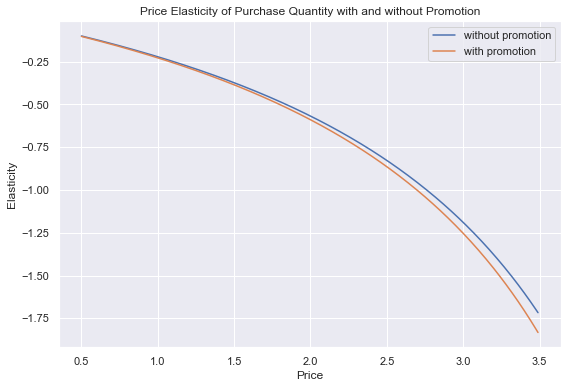

In [42]:
# Plot the two price elasticities of purchase quantity with and without promotion. 
plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_quantity_promotion_no, label = 'without promotion')
plt.plot(price_range, price_elasticity_quantity_promotion_yes, label = 'with promotion')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.legend()
plt.title('Price Elasticity of Purchase Quantity with and without Promotion')
plt.show()

> **Results and Interpretation:**
- Customers are a tiny bit more elastic when there is a promotion. 
- However, overall customers are inelastic towards purchase quantity for all prices from 0.5-2.7. The most expensive brand cost 2.8 dollars at most. Furthermore promotion doesn't look like such a big factor either.
- The two lines practically overlap at many of the price points. The reason might be that the variables that included in the model hold no predictive value. Therefore it might seem like it doesn't really make sense to focus too much on the purchase quantity. Neither price nor promotions shifts appear to affect the customer's decision.